# Wine Quality Prediction: Tabular Foundation Models vs. Tree-Based Methods

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
hf_token = os.getenv("HFTOKEN")

Shape: (4898, 12)
Columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

Dtypes:
 fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Missing values per column:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Head:
    fixed acidity  vo

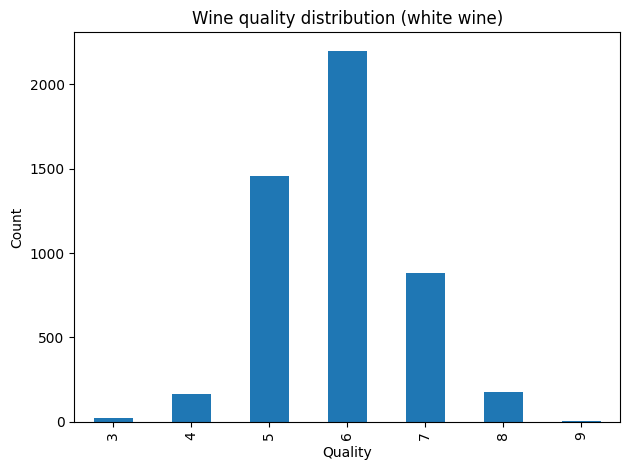

In [2]:
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import (
    root_mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)

from tabpfn import TabPFNRegressor, TabPFNClassifier
from tabicl import TabICLClassifier

path = "./data/winequality-white.csv"
df = pd.read_csv(path, sep=";")

print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("\nDtypes:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())

pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 50)

print("\nHead:\n", df.head())
print("\nSummary stats:\n", df.describe(include="all").T)

target_col = "quality"
quality_counts = df[target_col].value_counts().sort_index()
print("\nQuality value counts:\n", quality_counts)

feature_cols = [c for c in df.columns if c != target_col]

X = df[feature_cols]
y = df[target_col]

plt.figure()
quality_counts.plot(kind="bar")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.title("Wine quality distribution (white wine)")
plt.tight_layout()
plt.show()

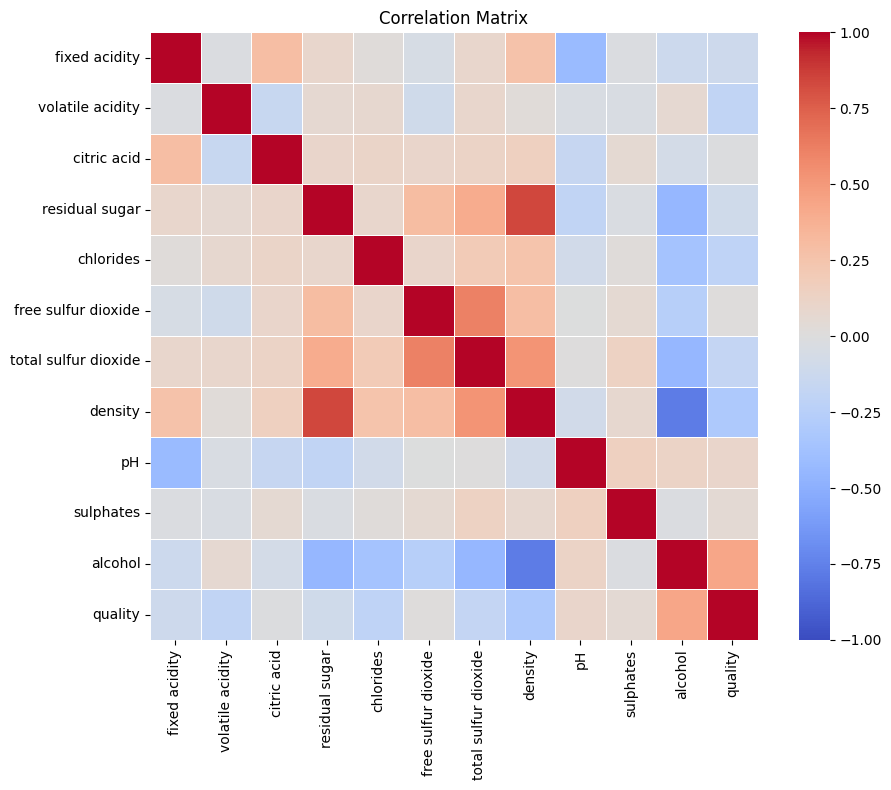

In [3]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    vmin=-1, vmax=1,
    cmap="coolwarm",
    annot=False,
    square=True,
    linewidths=0.5
)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


In [4]:
def timed_fit_predict(model, X_tr, y_tr, X_te):
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    model.fit(X_tr, y_tr)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    fit_s = time.perf_counter() - t0

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    y_hat = model.predict(X_te)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    pred_s = time.perf_counter() - t0

    return y_hat, fit_s, pred_s

### TabPFN (Regressor)

In [5]:
fold_summaries = []
all_y_true, all_y_pred = [], []

kf = KFold(n_splits=5, shuffle=True, random_state=21)

rmses, maes, r2s = [], [], []
fit_times, pred_times = [], []

warm_model = TabPFNRegressor(device="cuda")
_ = warm_model.fit(X.iloc[:256], y.iloc[:256])
_ = warm_model.predict(X.iloc[:256])
if torch.cuda.is_available():
    torch.cuda.synchronize()

for fold, (tr_idx, te_idx) in enumerate(kf.split(X), 1):
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

    model = TabPFNRegressor(device="cuda")
    y_hat, fit_s, pred_s = timed_fit_predict(model, X_tr, y_tr, X_te)

    rmse = root_mean_squared_error(y_te, y_hat)
    mae = mean_absolute_error(y_te, y_hat)
    r2 = r2_score(y_te, y_hat)

    rmses.append(rmse); maes.append(mae); r2s.append(r2)
    fit_times.append(fit_s); pred_times.append(pred_s)

    fold_summaries.append(
        {"fold": fold, "rmse": rmse, "mae": mae, "r2": r2, "fit_s": fit_s, "pred_s": pred_s}
    )
    all_y_true.append(y_te.to_numpy())
    all_y_pred.append(np.asarray(y_hat))

    print(f"Fold {fold}: RMSE={rmse:.4f} MAE={mae:.4f} R2={r2:.4f} | fit={fit_s:.3f}s pred={pred_s:.3f}s")

print(
    f"\nTabPFN 5-fold CV: RMSE = {np.mean(rmses):.4f} ± {np.std(rmses):.4f}, "
    f"MAE = {np.mean(maes):.4f} ± {np.std(maes):.4f}, "
    f"R2 = {np.mean(r2s):.4f} ± {np.std(r2s):.4f}"
)
print(
    f"Timing: fit = {np.mean(fit_times):.2f}s ± {np.std(fit_times):.2f}, "
    f"predict = {np.mean(pred_times):.2f}s ± {np.std(pred_times):.2f}"
)

Fold 1: RMSE=0.5996 MAE=0.4383 R2=0.5172 | fit=0.421s pred=1.926s
Fold 2: RMSE=0.6080 MAE=0.4447 R2=0.5147 | fit=0.296s pred=1.947s
Fold 3: RMSE=0.6195 MAE=0.4659 R2=0.5064 | fit=0.298s pred=1.929s
Fold 4: RMSE=0.6235 MAE=0.4573 R2=0.5306 | fit=0.285s pred=1.934s
Fold 5: RMSE=0.6482 MAE=0.4607 R2=0.4796 | fit=0.280s pred=1.935s

TabPFN 5-fold CV: RMSE = 0.6198 ± 0.0165, MAE = 0.4534 ± 0.0103, R2 = 0.5097 ± 0.0169
Timing: fit = 0.32s ± 0.05, predict = 1.93s ± 0.01


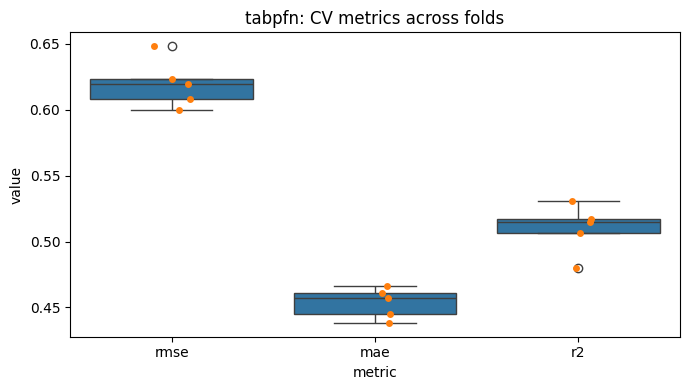

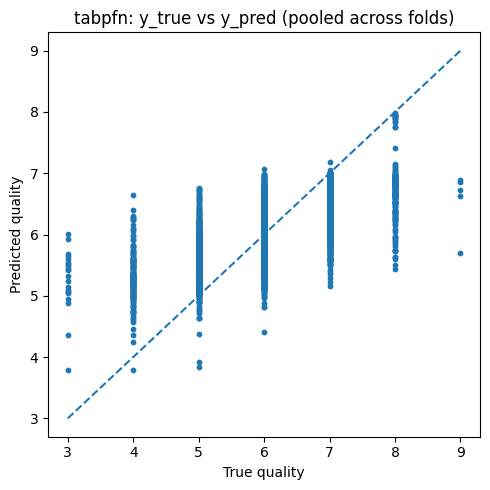

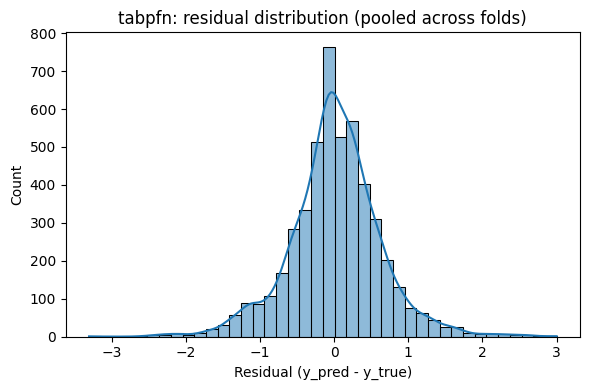

In [6]:
MODEL_RESULTS = globals().get("MODEL_RESULTS", {})

model_name = "tabpfn"

MODEL_RESULTS[model_name] = {
    "cv_metrics_df": pd.DataFrame(fold_summaries),
    "y_true_cv": np.concatenate(all_y_true).astype(float),
    "y_pred_cv": np.concatenate(all_y_pred).astype(float),
}

cv_metrics_df = MODEL_RESULTS[model_name]["cv_metrics_df"]
y_true_cv = MODEL_RESULTS[model_name]["y_true_cv"]
y_pred_cv = MODEL_RESULTS[model_name]["y_pred_cv"]

cv_metrics_long_df = cv_metrics_df.melt(
    id_vars=["fold"],
    value_vars=["rmse", "mae", "r2"],
    var_name="metric",
    value_name="value",
)

plt.figure(figsize=(7, 4))
sns.boxplot(data=cv_metrics_long_df, x="metric", y="value")
sns.stripplot(data=cv_metrics_long_df, x="metric", y="value", jitter=True, size=5)
plt.title(f"{model_name}: CV metrics across folds")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
plt.scatter(y_true_cv, y_pred_cv, s=10)
mn = float(min(y_true_cv.min(), y_pred_cv.min()))
mx = float(max(y_true_cv.max(), y_pred_cv.max()))
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlabel("True quality")
plt.ylabel("Predicted quality")
plt.title(f"{model_name}: y_true vs y_pred (pooled across folds)")
plt.tight_layout()
plt.show()

residuals_cv = y_pred_cv - y_true_cv
plt.figure(figsize=(6, 4))
sns.histplot(residuals_cv, bins=40, kde=True)
plt.xlabel("Residual (y_pred - y_true)")
plt.title(f"{model_name}: residual distribution (pooled across folds)")
plt.tight_layout()
plt.show()


### TabPFN (Classifier)

Positive rate (quality>=7): 0.21641486320947326
Majority baseline accuracy: 0.7835851367905268


tabpfn-v2.5-classifier-v2.5_default.ckpt:   0%|          | 0.00/42.9M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

Fold 1: ACC=0.8827 AUC=0.9133 | fit=0.249s pred=1.938s
Fold 2: ACC=0.8857 AUC=0.9272 | fit=0.234s pred=1.932s
Fold 3: ACC=0.8745 AUC=0.9192 | fit=0.270s pred=1.976s
Fold 4: ACC=0.8856 AUC=0.9256 | fit=0.231s pred=1.951s
Fold 5: ACC=0.8846 AUC=0.9175 | fit=0.246s pred=1.953s

tabpfn 5-fold CV: ACC=0.8826±0.0047, AUC=0.9206±0.0058
Timing: fit=0.25s±0.02, predict=1.95s±0.02


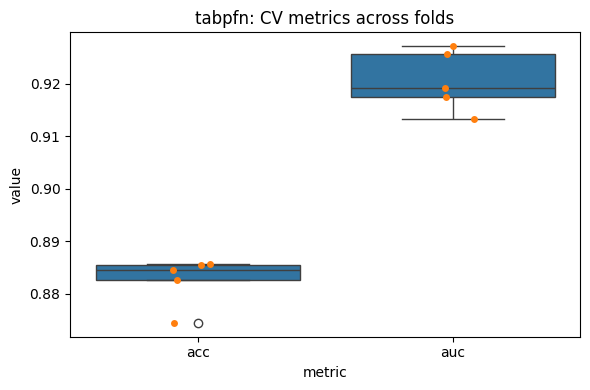

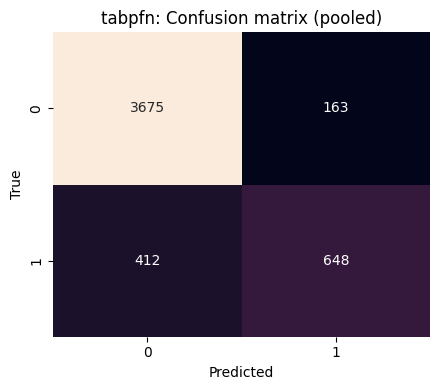

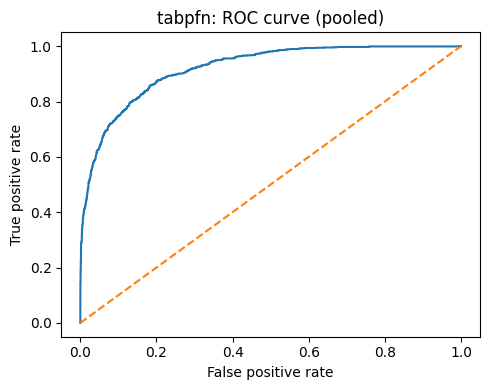

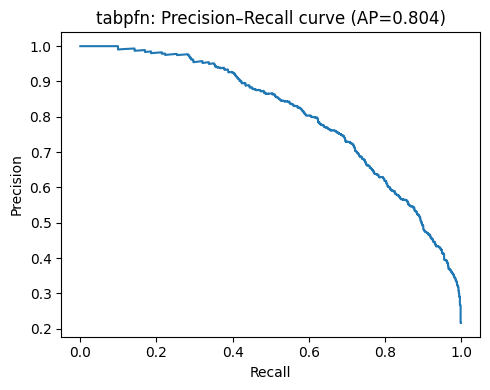

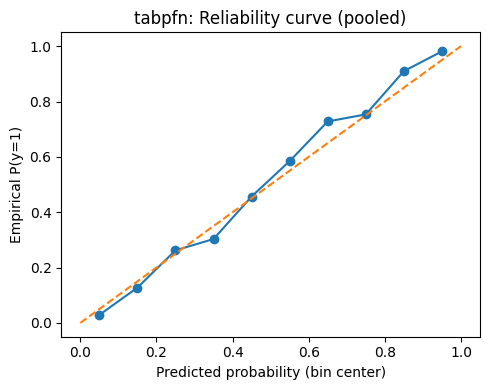

In [ ]:
MODEL_RESULTS = globals().get("MODEL_RESULTS", {})

model_name = "tabpfn"
y_bin = (y >= 7).astype(int)

p = y_bin.mean()
print("Positive rate (quality>=7):", p)
print("Majority baseline accuracy:", max(p, 1 - p))

kf = KFold(n_splits=5, shuffle=True, random_state=20)

fold_summaries = []
all_y_true, all_y_pred, all_y_proba = [], [], []

# Warm-up
warm_model = TabPFNClassifier(device="cuda")
_ = warm_model.fit(X.iloc[:256], y_bin.iloc[:256])
_ = warm_model.predict_proba(X.iloc[:256])
if torch.cuda.is_available():
    torch.cuda.synchronize()

for fold, (tr_idx, te_idx) in enumerate(kf.split(X), 1):
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y_bin.iloc[tr_idx], y_bin.iloc[te_idx]

    model = TabPFNClassifier(device="cuda")

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    model.fit(X_tr, y_tr)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    fit_s = time.perf_counter() - t0

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    proba = model.predict_proba(X_te)[:, 1]
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    pred_s = time.perf_counter() - t0

    y_hat = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_te, y_hat)
    auc = roc_auc_score(y_te, proba)

    fold_summaries.append({"fold": fold, "acc": acc, "auc": auc, "fit_s": fit_s, "pred_s": pred_s})
    all_y_true.append(y_te.to_numpy())
    all_y_pred.append(y_hat)
    all_y_proba.append(proba)

    print(f"Fold {fold}: ACC={acc:.4f} AUC={auc:.4f} | fit={fit_s:.3f}s pred={pred_s:.3f}s")

cv_metrics_df = pd.DataFrame(fold_summaries)
y_true_cv = np.concatenate(all_y_true)
y_pred_cv = np.concatenate(all_y_pred)
y_proba_cv = np.concatenate(all_y_proba)

MODEL_RESULTS[model_name] = {
    "cv_metrics_df": cv_metrics_df,
    "y_true_cv": y_true_cv,
    "y_pred_cv": y_pred_cv,
    "y_proba_cv": y_proba_cv,
}

print(
    f"\n{model_name} 5-fold CV: "
    f"ACC={cv_metrics_df['acc'].mean():.4f}±{cv_metrics_df['acc'].std():.4f}, "
    f"AUC={cv_metrics_df['auc'].mean():.4f}±{cv_metrics_df['auc'].std():.4f}"
)
print(
    f"Timing: fit={cv_metrics_df['fit_s'].mean():.2f}s±{cv_metrics_df['fit_s'].std():.2f}, "
    f"predict={cv_metrics_df['pred_s'].mean():.2f}s±{cv_metrics_df['pred_s'].std():.2f}"
)

# Plots

# CV metrics across folds
metrics_long = cv_metrics_df.melt(
    id_vars=["fold"],
    value_vars=["acc", "auc"],
    var_name="metric",
    value_name="value",
)
plt.figure(figsize=(6, 4))
sns.boxplot(data=metrics_long, x="metric", y="value")
sns.stripplot(data=metrics_long, x="metric", y="value", jitter=True, size=5)
plt.title(f"{model_name}: CV metrics across folds")
plt.tight_layout()
plt.show()

# Confusion matrix (pooled)
cm = confusion_matrix(y_true_cv, y_pred_cv)
plt.figure(figsize=(4.5, 4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"{model_name}: Confusion matrix (pooled)")
plt.tight_layout()
plt.show()

# ROC curve (pooled)
fpr, tpr, _ = roc_curve(y_true_cv, y_proba_cv)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title(f"{model_name}: ROC curve (pooled)")
plt.tight_layout()
plt.show()

# Precision–Recall curve (pooled)
prec, rec, _ = precision_recall_curve(y_true_cv, y_proba_cv)
ap = average_precision_score(y_true_cv, y_proba_cv)
plt.figure(figsize=(5, 4))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"{model_name}: Precision–Recall curve (AP={ap:.3f})")
plt.tight_layout()
plt.show()

# Reliability curve
bins = np.linspace(0.0, 1.0, 11)
bin_ids = np.digitize(y_proba_cv, bins) - 1

bin_centers, frac_pos = [], []
for b in range(len(bins) - 1):
    m = bin_ids == b
    if m.sum() == 0:
        continue
    bin_centers.append((bins[b] + bins[b + 1]) / 2)
    frac_pos.append(y_true_cv[m].mean())

plt.figure(figsize=(5, 4))
plt.plot(bin_centers, frac_pos, marker="o")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Predicted probability (bin center)")
plt.ylabel("Empirical P(y=1)")
plt.title(f"{model_name}: Reliability curve (pooled)")
plt.tight_layout()
plt.show()


### TabICL

Positive rate (quality>=7): 0.21641486320947326
Majority baseline accuracy: 0.7835851367905268
Fold 1: ACC=0.8806 AUC=0.9227 | fit=0.387s pred=2.895s
Fold 2: ACC=0.8837 AUC=0.9320 | fit=0.360s pred=2.915s
Fold 3: ACC=0.8837 AUC=0.9295 | fit=0.361s pred=2.919s
Fold 4: ACC=0.8846 AUC=0.9365 | fit=0.365s pred=2.855s
Fold 5: ACC=0.8897 AUC=0.9287 | fit=0.406s pred=2.940s

tabicl 5-fold CV: ACC=0.8844±0.0033, AUC=0.9299±0.0051
Timing: fit=0.38s±0.02, predict=2.90s±0.03


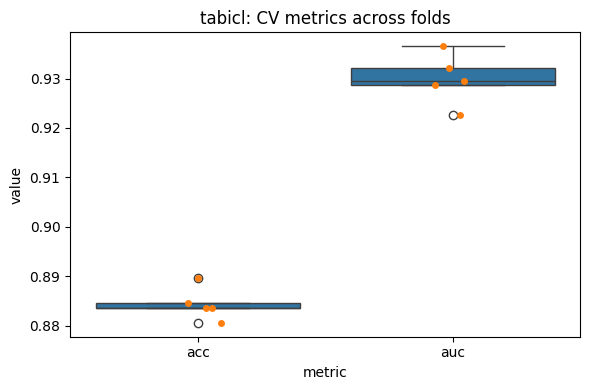

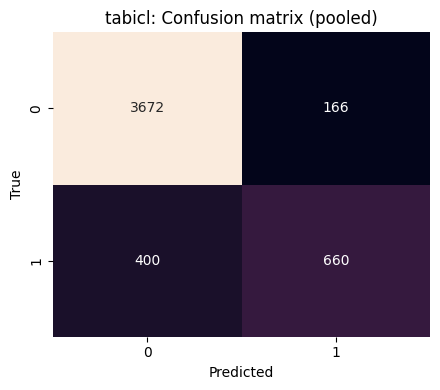

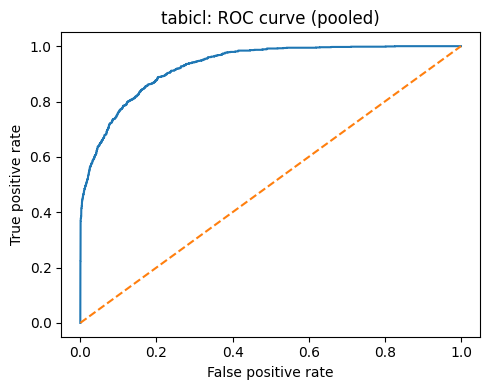

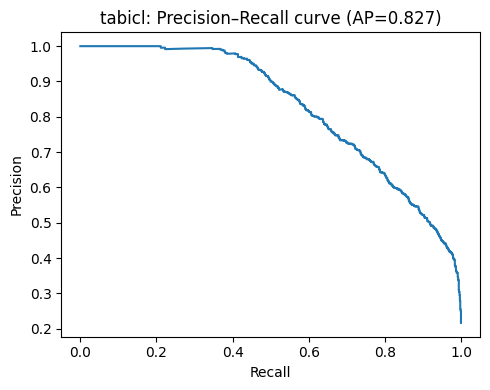

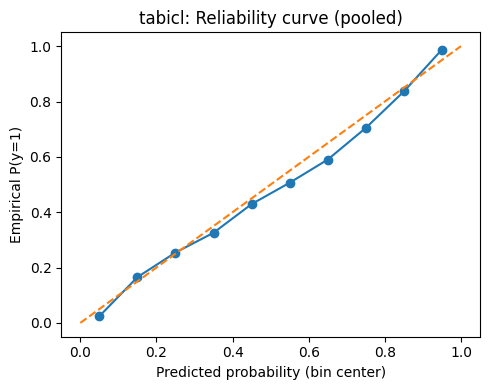

In [ ]:
MODEL_RESULTS = globals().get("MODEL_RESULTS", {})

model_name = "tabicl"
y_bin = (y >= 7).astype(int)

p = y_bin.mean()
print("Positive rate (quality>=7):", p)
print("Majority baseline accuracy:", max(p, 1-p))

kf = KFold(n_splits=5, shuffle=True, random_state=20)

fold_summaries = []
all_y_true, all_y_pred, all_y_proba = [], [], []

# Warm-up
warm_model = TabICLClassifier()
_ = warm_model.fit(X.iloc[:256], y_bin.iloc[:256])
_ = warm_model.predict_proba(X.iloc[:256])
if torch.cuda.is_available():
    torch.cuda.synchronize()

for fold, (tr_idx, te_idx) in enumerate(kf.split(X), 1):
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y_bin.iloc[tr_idx], y_bin.iloc[te_idx]

    model = TabICLClassifier()

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    model.fit(X_tr, y_tr)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    fit_s = time.perf_counter() - t0

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    proba = model.predict_proba(X_te)[:, 1]
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    pred_s = time.perf_counter() - t0

    y_hat = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_te, y_hat)
    auc = roc_auc_score(y_te, proba)

    fold_summaries.append({"fold": fold, "acc": acc, "auc": auc, "fit_s": fit_s, "pred_s": pred_s})
    all_y_true.append(y_te.to_numpy())
    all_y_pred.append(y_hat)
    all_y_proba.append(proba)

    print(f"Fold {fold}: ACC={acc:.4f} AUC={auc:.4f} | fit={fit_s:.3f}s pred={pred_s:.3f}s")

cv_metrics_df = pd.DataFrame(fold_summaries)
y_true_cv = np.concatenate(all_y_true)
y_pred_cv = np.concatenate(all_y_pred)
y_proba_cv = np.concatenate(all_y_proba)

MODEL_RESULTS[model_name] = {
    "cv_metrics_df": cv_metrics_df,
    "y_true_cv": y_true_cv,
    "y_pred_cv": y_pred_cv,
    "y_proba_cv": y_proba_cv,
}

print(
    f"\n{model_name} 5-fold CV: "
    f"ACC={cv_metrics_df['acc'].mean():.4f}±{cv_metrics_df['acc'].std():.4f}, "
    f"AUC={cv_metrics_df['auc'].mean():.4f}±{cv_metrics_df['auc'].std():.4f}"
)
print(
    f"Timing: fit={cv_metrics_df['fit_s'].mean():.2f}s±{cv_metrics_df['fit_s'].std():.2f}, "
    f"predict={cv_metrics_df['pred_s'].mean():.2f}s±{cv_metrics_df['pred_s'].std():.2f}"
)

# Plots

# CV metrics across folds
metrics_long = cv_metrics_df.melt(
    id_vars=["fold"],
    value_vars=["acc", "auc"],
    var_name="metric",
    value_name="value",
)
plt.figure(figsize=(6, 4))
sns.boxplot(data=metrics_long, x="metric", y="value")
sns.stripplot(data=metrics_long, x="metric", y="value", jitter=True, size=5)
plt.title(f"{model_name}: CV metrics across folds")
plt.tight_layout()
plt.show()

# Confusion matrix (pooled)
cm = confusion_matrix(y_true_cv, y_pred_cv)
plt.figure(figsize=(4.5, 4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"{model_name}: Confusion matrix (pooled)")
plt.tight_layout()
plt.show()

# ROC curve (pooled)
fpr, tpr, _ = roc_curve(y_true_cv, y_proba_cv)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title(f"{model_name}: ROC curve (pooled)")
plt.tight_layout()
plt.show()

# Precision–Recall curve (pooled)
prec, rec, _ = precision_recall_curve(y_true_cv, y_proba_cv)
ap = average_precision_score(y_true_cv, y_proba_cv)
plt.figure(figsize=(5, 4))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"{model_name}: Precision–Recall curve (AP={ap:.3f})")
plt.tight_layout()
plt.show()

# Reliability curve
bins = np.linspace(0.0, 1.0, 11)
bin_ids = np.digitize(y_proba_cv, bins) - 1

bin_centers, frac_pos = [], []
for b in range(len(bins) - 1):
    m = bin_ids == b
    if m.sum() == 0:
        continue
    bin_centers.append((bins[b] + bins[b + 1]) / 2)
    frac_pos.append(y_true_cv[m].mean())

plt.figure(figsize=(5, 4))
plt.plot(bin_centers, frac_pos, marker="o")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Predicted probability (bin center)")
plt.ylabel("Empirical P(y=1)")
plt.title(f"{model_name}: Reliability curve (pooled)")
plt.tight_layout()
plt.show()
